In [1]:
## Import all necessary libraries

# Pandas, numpy, matplotlib, seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bigram, Trigram combinations
import itertools
from itertools import combinations

# Biopython for protein analysis
from Bio import SeqIO, SeqUtils
from Bio.SeqUtils import ProtParamData
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Sklearn
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV

# Classsifiers
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier

In [2]:
#Load fasta sequence data
cyto = 'data/cyto.fasta.txt'
mito = 'data/mito.fasta.txt'
nucleus = 'data/nucleus.fasta.txt'
secreted = 'data/secreted.fasta.txt'
blind = 'data/blind.fasta.txt'

In [3]:
#Load 'cyto' data into dataframe and add label
with open(cyto) as file:  
    identifiers = []
    cytosequences = []
    for seq_record in SeqIO.parse(file, 'fasta'):  
        identifiers.append(seq_record.id)
        cytosequences.append(seq_record.seq)

cyto_df = pd.DataFrame.from_records(cytosequences)
cyto_df['label'] = 'cyto'

#Replace None entries with NaN: useful for features later
cyto_df.fillna(value=np.nan, inplace=True)

In [4]:
#Load 'mito' data into dataframe and add label
with open(mito) as file:  
    identifiers = []
    mitosequences = []
    for seq_record in SeqIO.parse(file, 'fasta'):  
        identifiers.append(seq_record.id)
        mitosequences.append(seq_record.seq)

mito_df = pd.DataFrame.from_records(mitosequences)
mito_df['label'] = 'mito'

#Replace None entries with NaN: useful for features later
mito_df.fillna(value=np.nan, inplace=True)

In [5]:
#Load 'nucleus' data into dataframe and add label
with open(nucleus) as file:  
    identifiers = []
    nucsequences = []
    for seq_record in SeqIO.parse(file, 'fasta'):  
        identifiers.append(seq_record.id)
        nucsequences.append(seq_record.seq)

nucleus_df = pd.DataFrame.from_records(nucsequences)
nucleus_df['label'] = 'nucleus'

#Replace None entries with NaN: useful for features later
nucleus_df.fillna(value=np.nan, inplace=True)

In [6]:
#Load 'secreted' data into dataframe and add label
with open(secreted) as file:  
    identifiers = []
    secsequences = []
    for seq_record in SeqIO.parse(file, 'fasta'):  
        identifiers.append(seq_record.id)
        secsequences.append(seq_record.seq)

secreted_df = pd.DataFrame.from_records(secsequences)
secreted_df['label'] = 'secreted'

#Replace None entries with NaN: useful for features later
secreted_df.fillna(value=np.nan, inplace=True)

In [7]:
#Load 'blind' data into dataframe and add label
with open(blind) as file:  
    blindidentifiers = []
    blindsequences = []
    for seq_record in SeqIO.parse(file, 'fasta'):  
        blindidentifiers.append(seq_record.id)
        blindsequences.append(seq_record.seq)

blind_df = pd.DataFrame.from_records(blindsequences)
blind_df['label'] = 'blind'

#Replace None entries with NaN: useful for features later
blind_df.fillna(value=np.nan, inplace=True)

In [8]:
# All sequence data
sequences = cytosequences+mitosequences+nucsequences+secsequences+blindsequences

In [9]:
#Concatanate the dataframes into one with all the sequence data
full_data=pd.concat([cyto_df,mito_df,nucleus_df,secreted_df,blind_df],0,ignore_index=True)

In [10]:
#Reindex the label column as the last column
cols = full_data.columns.tolist()
cols.insert(np.shape(full_data)[1], cols.pop(cols.index('label')))
full_data = full_data.reindex(columns= cols)
full_data.head()

,0,1,2,3,4,5,6,7,8,9,...,13091,13092,13093,13094,13095,13096,13097,13098,13099,label
0,M,G,Q,Q,V,G,R,V,G,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cyto
1,M,A,L,E,P,I,D,Y,T,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cyto
2,M,N,Q,I,E,P,G,V,Q,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cyto
3,M,S,E,E,P,T,P,V,S,G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cyto
4,M,G,D,W,M,T,V,T,D,P,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cyto


In [11]:
# Split labels column from data
labels = full_data.pop('label')

In [12]:
# Define the train test split point
train_idx = 9222
train = full_data[:train_idx]
test = full_data[train_idx:]

In [13]:
# Feature engineering starts here 
# i.e. find relevant features for the sequence data

# 1. Sequence length
sequence_length = pd.DataFrame(full_data.count(axis=1),columns=['seq_len'])
sequence_length = sequence_length.astype(float)

# 2. Global amino acid count i.e. no of amino acid per sequence
global_count = full_data.T

d = {}
for i in range(len(full_data)):
    series_global = global_count.groupby(i).size()
    d[str(i)]=pd.DataFrame({i:series_global.values},index = series_global.index+' global')

global_counts_feats = pd.concat([d[str(i)] for i in range(len(d))],axis=1)
global_counts_feats = global_counts_feats.fillna(0)
global_counts_feats = global_counts_feats.T

# 3. Bigram amino counts i.e (AB, AC, AE etc)
aminos = pd.DataFrame(series_global.index)
aminos.columns = ['amino']

bigrams = pd.DataFrame(list(combinations(aminos.amino, 2)))
bigrams = bigrams.apply(lambda x: ''.join(x), axis=1)
bicnt=[]

for seq in sequences:
    for bi in bigrams:
        bicnt.append(seq.count(bi))
        
bigramcounts = [bicnt[i:i+len(bigrams)] for i  in range(0, len(bicnt), len(bigrams))]

bigram_count_df = pd.DataFrame(bigramcounts)
bigram_count_df.columns = bigrams

# 4. Trigram amino counts i.e (ABC, ACE etc)
aminos = pd.DataFrame(series_global.index)
aminos.columns = ['amino']

from itertools import combinations
sequences = cytosequences+mitosequences+nucsequences+secsequences+blindsequences
trigrams = pd.DataFrame(list(combinations(aminos.amino, 3)))
trigrams = trigrams.apply(lambda x: ''.join(x), axis=1)
tricnt=[]

for seq in sequences:
    for tri in trigrams:
        tricnt.append(seq.count(tri))
trigramcounts = [tricnt[i:i+len(trigrams)] for i  in range(0, len(tricnt), len(trigrams))]

trigram_count_df = pd.DataFrame(trigramcounts)
trigram_count_df.columns = trigrams

# Find the best split for local amino count
aminoFirstCount=[]
aminoLastCount=[]
cnt = np.arange(10,60,10)

for j in cnt:
    for i in range(len(sequences)):
            X=ProteinAnalysis(str(sequences[i][j:]))
            aminoFirstCount.append(X.count_amino_acids())
for j in cnt:
    for i in range(len(sequences)):
            X=ProteinAnalysis(str(sequences[i][:j]))
            aminoLastCount.append(X.count_amino_acids())

aminofirstchunk = [aminoFirstCount[i:i+len(sequences)] for i  in range(0, len(aminoFirstCount), len(sequences))]
aminofirst10 = pd.DataFrame(aminofirstchunk[0])
aminofirst10.columns = [str(cols)+'_first' for cols in aminofirst10.columns]
aminofirst20 = pd.DataFrame(aminofirstchunk[1])
aminofirst20.columns = [str(cols)+'_first' for cols in aminofirst20.columns]
aminofirst30 = pd.DataFrame(aminofirstchunk[2])
aminofirst30.columns = [str(cols)+'_first' for cols in aminofirst30.columns]
aminofirst40 = pd.DataFrame(aminofirstchunk[3])
aminofirst40.columns = [str(cols)+'_first' for cols in aminofirst40.columns]
aminofirst50 = pd.DataFrame(aminofirstchunk[4])
aminofirst50.columns = [str(cols)+'_first' for cols in aminofirst50.columns]

aminolastchunk = [aminoLastCount[i:i+len(sequences)] for i  in range(0, len(aminoLastCount), len(sequences))]
aminolast10 = pd.DataFrame(aminolastchunk[0])
aminolast10.columns = [str(cols)+'_last' for cols in aminolast10.columns]
aminolast20 = pd.DataFrame(aminolastchunk[1])
aminolast20.columns = [str(cols)+'_last' for cols in aminolast20.columns]
aminolast30 = pd.DataFrame(aminolastchunk[2])
aminolast30.columns = [str(cols)+'_last' for cols in aminolast30.columns]
aminolast40 = pd.DataFrame(aminolastchunk[3])
aminolast40.columns = [str(cols)+'_last' for cols in aminolast40.columns]
aminolast50 = pd.DataFrame(aminolastchunk[4])
aminolast50.columns = [str(cols)+'_last' for cols in aminolast50.columns]

acc=[]
feats=[]

for feat_first, featfirst_name in zip([aminofirst10, aminofirst20, aminofirst30, aminofirst40, aminofirst50], 
                      ['First 10%', 'First 20%', 'First 30%','First 40%', 'First 50%']):    
    for feat_last, featlast_name in zip([aminolast10, aminolast20, aminolast30, aminolast40, aminolast50], 
                      ['Last 10%', 'Last 20%', 'Last 30%','Last 40%', 'Last 50%']):   
        features_df = pd.concat([feat_first, feat_last],1)
        labels = labels[:train_idx]
        test_df = features_df[train_idx:]
        features_df = features_df[:train_idx]
        le = preprocessing.LabelEncoder()
        le.fit(labels.values)
        labels_enc=le.transform(labels)
        labels_df = pd.DataFrame(labels_enc,columns=['labels'])
        X_train, X_test, y_train, y_test = train_test_split(features_df, labels_enc, random_state=0, test_size=0.3)
        lr = LogisticRegression()
        y_pred_lr = lr.fit(X_train, y_train).predict(X_test)
        acc.append(metrics.accuracy_score(y_test, y_pred_lr))
        feats.append([featfirst_name, featlast_name])
results = pd.DataFrame()
results['Accuracy'] = acc
results['Combinations'] = feats
        

results = results.sort_values(by='Accuracy', ascending=False)


# 6. First 50 amino acid count 
local_count_first50 = global_count.drop(global_count.index[50:])

d = {}
for i in range(len(full_data)):
    series_global = local_count_first50.groupby(i).size()
    d[str(i)]=pd.DataFrame({i:series_global.values},index = series_global.index+' first50')

first50_counts_feats = pd.concat([d[str(i)] for i in range(len(d))],axis=1)
first50_counts_feats = first50_counts_feats.fillna(0)
first50_counts_feats = first50_counts_feats.T

# 7. Last 50 amino acid count 
local_count_last50 = global_count.drop(global_count.index[:50])

d = {}
for i in range(len(full_data)):
    series_global = local_count_last50.groupby(i).size()
    d[str(i)]=pd.DataFrame({i:series_global.values},index = series_global.index+' last50')

last50_counts_feats = pd.concat([d[str(i)] for i in range(len(d))],axis=1)
last50_counts_feats = last50_counts_feats.fillna(0)
last50_counts_feats = last50_counts_feats.T

## Biopython Protein Analysis Features
# 8. Isoelectric Point
# 9. Aromaticity
# 10. Secondary Structure Fraction
# 11. Gravy
# 12. Instability Index
# 13. Flexibility
# 14. Amino Percent
# 15. Molecular Weight
# 16. Protein Scale ~ Hydrophobicity
# 17. Protein Scale ~ Hydrophilicity
# 18. Protein Scale ~ Surface accessibility 

sequences = cytosequences+mitosequences+nucsequences+secsequences+blindsequences
isoelectricPt=[]
aromaticity=[]
aminoPercent=[]
secstruct=[]
hydrophob=[]
hydrophil=[]
surface=[]
gravy=[]
molweight=[]
instidx=[]
flex=[]

for seq in sequences:
        X=ProteinAnalysis(str(seq))
        isoelectricPt.append(X.isoelectric_point())
        aromaticity.append(X.aromaticity())  
        aminoPercent.append(X.get_amino_acids_percent())
        secstruct.append(X.secondary_structure_fraction())

# These features throw Key & Value Errors due to non standard amino acids
# (i.e. out of the 20 standard ones) e.g. X, U etc
        try:
            gravy.append(X.gravy())
            molweight.append(X.molecular_weight())
            instidx.append(X.instability_index())
            flex.append(X.flexibility())
            hydrophob.append(X.protein_scale(ProtParamData.kd, 9, 0.4))
            hydrophil.append(X.protein_scale(ProtParamData.hw, 9, 0.4))
            surface.append(X.protein_scale(ProtParamData.em, 9, 0.4))

        except (KeyError,ValueError):
            gravy.append(0)
            molweight.append(0)
            instidx.append(0)
            flex.append([0,0])
            hydrophob.append([0,0])
            hydrophil.append([0,0])
            surface.append([0,0])

isoelectricPt_df = pd.DataFrame(isoelectricPt,columns=['isoelectricPt'])
aromaticity_df = pd.DataFrame(aromaticity,columns=['aromaticity'])
aminoPercent_df = pd.DataFrame()
aminoPercent_df = aminoPercent_df.from_dict(aminoPercent)
aminoPercent_df.columns = [str(col) + '%' for col in aminoPercent_df.columns]
secstruct_df = pd.DataFrame(secstruct,columns=['helix','turn','sheet'])
instidx_df = pd.DataFrame(instidx, columns=['instabilityIdx'])
gravy_df = pd.DataFrame(gravy, columns=['gravy'])
molWeight_df = pd.DataFrame(molweight, columns=['molWeight'])
flex_df = pd.DataFrame(pd.DataFrame(flex).mean(axis=1), columns=['flexibility'])
hydrophob_df = pd.DataFrame(pd.DataFrame(hydrophob).mean(axis=1), columns=['hydrophobicity'])
hydrophil_df = pd.DataFrame(pd.DataFrame(hydrophil).mean(axis=1), columns=['hydrophilicity'])
surface_df = pd.DataFrame(pd.DataFrame(surface).mean(axis=1), columns=['surface_accesibility'])

In [15]:
# Final feature dataframe to be used for model
features_df = pd.concat([sequence_length,secstruct_df, flex_df,isoelectricPt_df,aromaticity_df,instidx_df,
                         gravy_df,aminoPercent_df,hydrophob_df, hydrophil_df, surface_df, molWeight_df,
                         global_counts_feats,aminofirst20,aminolast40], 1)

features_df.head(10)

,seq_len,helix,turn,sheet,flexibility,isoelectricPt,aromaticity,instabilityIdx,gravy,A%,...,M_last,N_last,P_last,Q_last,R_last,S_last,T_last,V_last,W_last,Y_last
0,1182.0,0.241963,0.296108,0.252961,1.008064,7.965393,0.067682,52.288164,-0.509983,0.082064,...,1,0,5,5,8,3,0,2,0,0
1,592.0,0.197635,0.285473,0.282095,1.025372,4.589172,0.060811,61.758615,-1.042061,0.094595,...,1,1,3,0,2,3,4,1,1,2
2,894.0,0.282998,0.164430,0.313199,1.003840,5.307678,0.078300,43.180884,-0.597315,0.083893,...,2,2,2,5,1,0,0,2,2,4
3,861.0,0.298490,0.188153,0.295006,1.007373,5.001526,0.073171,41.535075,-0.466783,0.078978,...,1,3,2,2,1,3,4,1,2,0
4,614.0,0.250814,0.214984,0.268730,1.012336,6.029358,0.061889,52.350000,-0.882410,0.032573,...,3,0,2,3,0,9,5,2,1,2
5,309.0,0.304207,0.216828,0.258900,1.002160,6.351501,0.119741,47.342104,-0.429773,0.067961,...,2,0,3,0,4,4,1,4,3,0
6,730.0,0.241096,0.257534,0.261644,1.013983,8.869812,0.047945,56.928630,-0.696027,0.065753,...,1,1,0,1,3,2,3,3,0,1
7,867.0,0.329873,0.235294,0.206459,0.998454,9.027649,0.089965,41.530242,-0.301384,0.041522,...,2,6,0,0,1,8,0,0,0,0
8,176.0,0.318182,0.238636,0.210227,1.001858,5.006897,0.096591,34.325568,-0.048295,0.090909,...,2,1,2,3,0,6,1,2,1,2
9,338.0,0.281065,0.215976,0.263314,1.007604,5.406067,0.094675,23.513343,-0.549704,0.059172,...,1,4,1,0,3,2,3,2,5,0


In [16]:
# Normalize the data
from sklearn.preprocessing import StandardScaler
features_df_scaled = features_df.copy()
scaler = StandardScaler().fit(features_df_scaled)
features_df_scaled = scaler.transform(features_df_scaled)

In [17]:
# Split out the test set
labels = labels[:train_idx]
test_df = features_df_scaled[train_idx:]
features_df_scaled = features_df_scaled[:train_idx]
features_df = features_df[:train_idx]

In [18]:
# Encoding the 4 class labels
le = preprocessing.LabelEncoder()
le.fit(labels.values)

labels_enc=le.transform(labels)
labels_df = pd.DataFrame(labels_enc,columns=['labels'])

In [29]:
# Split the training data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(features_df_scaled, labels_enc, random_state=0, test_size=0.3)

In [30]:
# Basic Logistic Regression model to test
lr = LogisticRegression()
y_pred_lr = lr.fit(X_train, y_train).predict(X_test)
print('LR Accuracy =', metrics.accuracy_score(y_test, y_pred_lr))

LR Accuracy = 0.655222262378


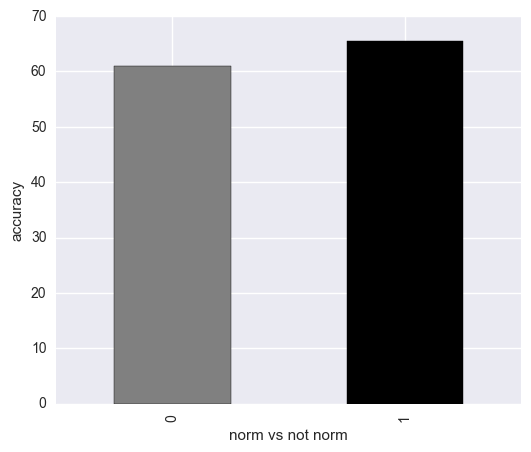

In [33]:
scorelist = [0.60968558005059637,0.655222262378]
norm_df = pd.DataFrame(scorelist)
norm_df['type'] = ['normalized','not normalized']
norm_df.columns = ['accuracy','type']
norm_df.accuracy = norm_df.accuracy *100
ax = norm_df.accuracy.plot(kind='bar', color=['grey', 'black'], figsize=(6,5))
ax.set_ylabel("accuracy")
ax.set_xlabel("norm vs not norm")
plt.show()

In [19]:
# Optimal parameters
param_df = pd.DataFrame()
param_df = param_df.from_csv('OptimizedEnsembleParams.csv')
opt_params = param_df.iloc[0][2:]
opt_params_df = pd.DataFrame(opt_params).T
opt_params_df

,lr__C,rf__n_estimators,rf__max_depth,ada__n_estimators,gbr__n_estimators,xg__max_depth,xg__min_child_weight,SVC__C,NN__hidden_layer_sizes,NN__activation,NN__solver,NN__alpha,KNN__n_neighbors
0,100,1200,5,300,500,15,7,100,"(300,)",relu,adam,1,4


# Randomized Search CV took 20429.92 seconds for 50 candidates parameter settings.


In [20]:
# Ensemble of classifiers
X = features_df_scaled
y = labels_enc

hidden_size = (int(opt_params_df.NN__hidden_layer_sizes[0].strip(") ( ,")),)

# Models with already tuned parameters
clf1 = LogisticRegression(C=opt_params_df.lr__C[0])
clf2 = RandomForestClassifier(n_estimators=int(opt_params_df.rf__n_estimators[0]),max_depth=opt_params_df.rf__max_depth[0])
clf3 = AdaBoostClassifier(n_estimators=int(opt_params_df.ada__n_estimators[0]))
clf4 = GradientBoostingClassifier(n_estimators=int(opt_params_df.gbr__n_estimators[0]))
clf5 = xgb.XGBClassifier(max_depth=int(opt_params_df.xg__max_depth[0]),min_child_weight=int(opt_params_df.xg__min_child_weight[0]))
clf6 = SVC(probability=True,C=opt_params_df.SVC__C[0])
clf7 = MLPClassifier(hidden_layer_sizes=hidden_size,activation=opt_params_df.NN__activation[0],
                     solver=opt_params_df.NN__solver[0],alpha=opt_params_df.NN__alpha[0])
clf8 = KNeighborsClassifier(n_neighbors=int(opt_params_df.KNN__n_neighbors))

# weights already tuned
weights = [10.0, 1.0, 4.0, 10.0, 11.0, 7.0, 11.0, 1.0]
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('ada', clf3), ('gbr', clf4), ('xgb', clf5),
                                   ('SVC', clf6), ('Neural', clf7), ('KNN', clf8)], voting='soft', 
                        weights=weights)

scores_list=[]
# Cross validation performance
for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8, eclf], 
                      ['Logistic Regression', 'Random Forest', 'Adaboost','Gradient Boosting', 
                       'XGboost', 'SVC', 'Neural Net','KNN', 'Ensemble']):
    scores = cross_val_score(clf, X, y, cv=2, scoring='accuracy')
    scores_list.append([label,scores.mean(),scores.std()])
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
scores_df = pd.DataFrame(scores_list)

Accuracy: 0.65 (+/- 0.01) [Logistic Regression]
Accuracy: 0.56 (+/- 0.01) [Random Forest]
Accuracy: 0.59 (+/- 0.01) [Adaboost]
Accuracy: 0.64 (+/- 0.01) [Gradient Boosting]
Accuracy: 0.65 (+/- 0.01) [XGboost]
Accuracy: 0.61 (+/- 0.01) [SVC]
Accuracy: 0.65 (+/- 0.01) [Neural Net]
Accuracy: 0.55 (+/- 0.00) [KNN]
Accuracy: 0.67 (+/- 0.01) [Ensemble]


In [21]:
scores_df.columns = ['classifier','mean_accuracy', 'std_accuracy']
scores_df.mean_accuracy = scores_df.mean_accuracy *100
scores_df.std_accuracy = scores_df.std_accuracy *100
scores_df

,classifier,mean_accuracy,std_accuracy
0,Logistic Regression,64.562816,0.853489
1,Random Forest,56.224110,0.627581
2,Adaboost,58.620476,0.984901
3,Gradient Boosting,63.912118,1.222314
4,XGboost,64.855503,1.276327
5,SVC,61.146984,1.255444
6,Neural Net,64.627779,1.308907
7,KNN,55.172440,0.120402
8,Ensemble,67.056791,1.134883


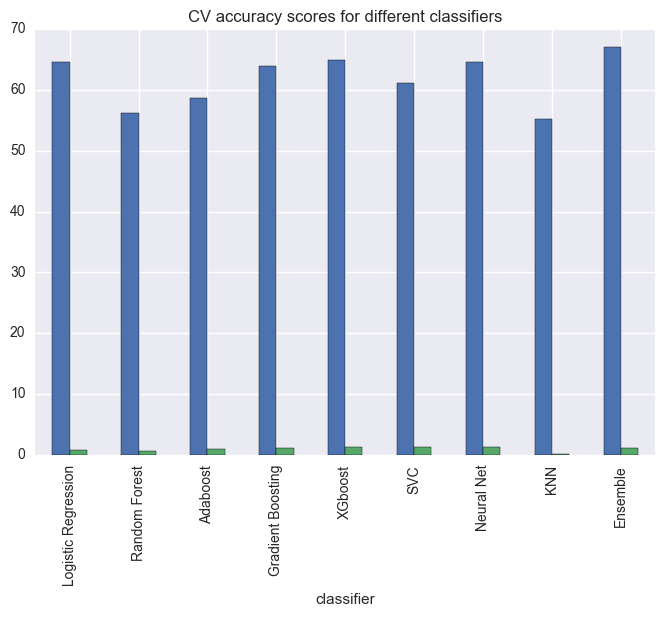

In [23]:
scores_df.plot(kind='bar', title='CV accuracy scores for different classifiers', x=scores_df.classifier, legend=None)
plt.show()

In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
rocaucs_list = []

# ROC AUC scores for class 4 i.e 'secreted'
for clf in(clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8, eclf):
    probas_ = clf.fit(X_train, y_train).predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test_bin[:, 2], probas_[:, 2])
    roc_auc = auc(fpr, tpr)
    rocaucs_list.append([fpr,tpr,roc_auc])

In [26]:
f, axes = plt.subplots(1, figsize=(10, 6))
for [fpr, tpr, roc_auc],label in zip(rocaucs_list,['Logistic Regression', 'Random Forest', 'Adaboost','Gradient Boosting', 
                       'XGboost', 'SVC', 'Neural Net','KNN', 'Ensemble']):
    lab = '%s AUC=%.4f' % (label,roc_auc)
    axes.step(fpr, tpr, lw=3,label=lab)
axes.legend(loc='lower right', fontsize='small')
plt.title('ROC AUC curve for nuclear class using different classifiers')
plt.savefig('rocNuc.png')

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
rocaucs_list = []

# ROC AUC scores for class 4 i.e 'secreted'
for clf in(clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8, eclf):
    probas_ = clf.fit(X_train, y_train).predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test_bin[:, 0], probas_[:, 0])
    roc_auc = auc(fpr, tpr)
    rocaucs_list.append([fpr,tpr,roc_auc])
   

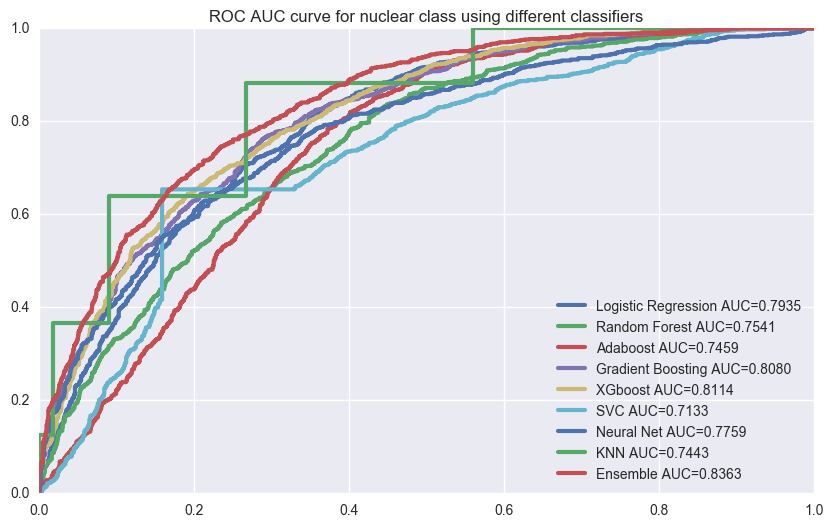

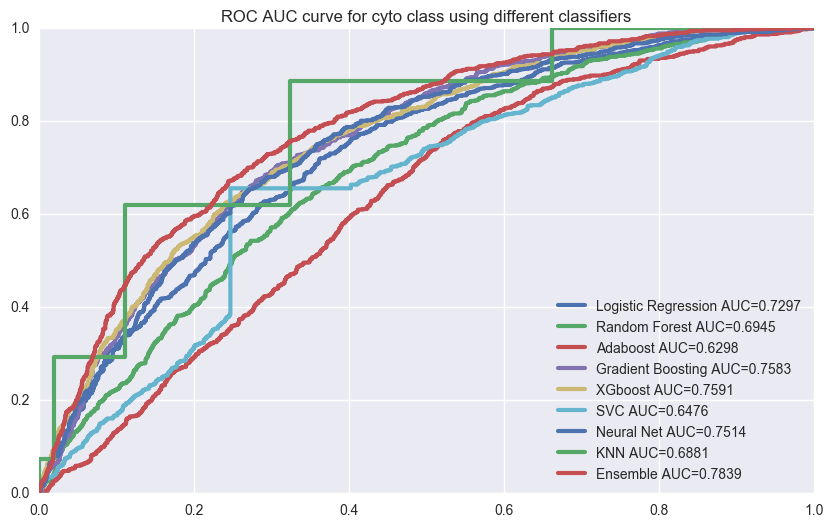

In [28]:
f, axes = plt.subplots(1, figsize=(10, 6))
for [fpr, tpr, roc_auc],label in zip(rocaucs_list,['Logistic Regression', 'Random Forest', 'Adaboost','Gradient Boosting', 
                       'XGboost', 'SVC', 'Neural Net','KNN', 'Ensemble']):
    lab = '%s AUC=%.4f' % (label,roc_auc)
    axes.step(fpr, tpr, lw=3,label=lab)
axes.legend(loc='lower right', fontsize='small')
plt.title('ROC AUC curve for cyto class using different classifiers')
plt.show()

In [29]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
rocaucs_list = []

# ROC AUC scores for class 4 i.e 'secreted'
for clf in(clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8, eclf):
    probas_ = clf.fit(X_train, y_train).predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test_bin[:, 1], probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    rocaucs_list.append([fpr,tpr,roc_auc])

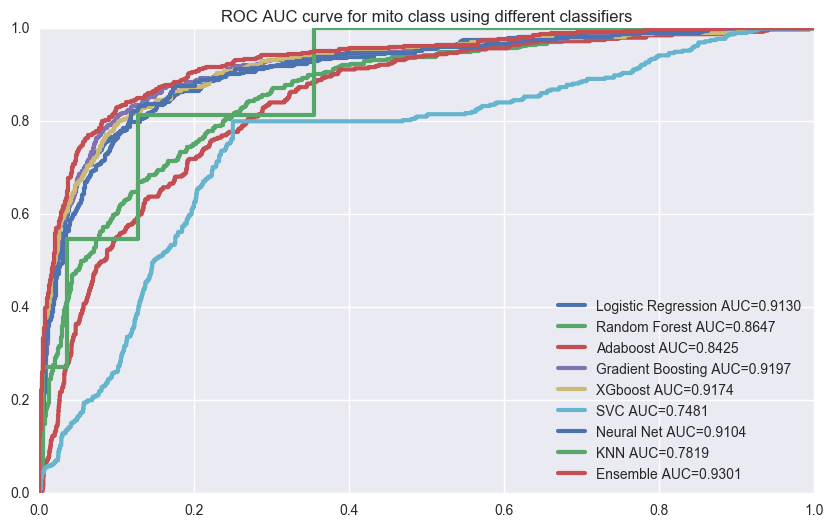

In [30]:
f, axes = plt.subplots(1, figsize=(10, 6))
for [fpr, tpr, roc_auc],label in zip(rocaucs_list,['Logistic Regression', 'Random Forest', 'Adaboost','Gradient Boosting', 
                       'XGboost', 'SVC', 'Neural Net','KNN', 'Ensemble']):
    lab = '%s AUC=%.4f' % (label,roc_auc)
    axes.step(fpr, tpr, lw=3,label=lab)
axes.legend(loc='lower right', fontsize='small')
plt.title('ROC AUC curve for mito class using different classifiers')
plt.show()

In [31]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
rocaucs_list = []

# ROC AUC scores for class 4 i.e 'secreted'
for clf in(clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8, eclf):
    probas_ = clf.fit(X_train, y_train).predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test_bin[:, 3], probas_[:, 3])
    roc_auc = auc(fpr, tpr)
    rocaucs_list.append([fpr,tpr,roc_auc])
    

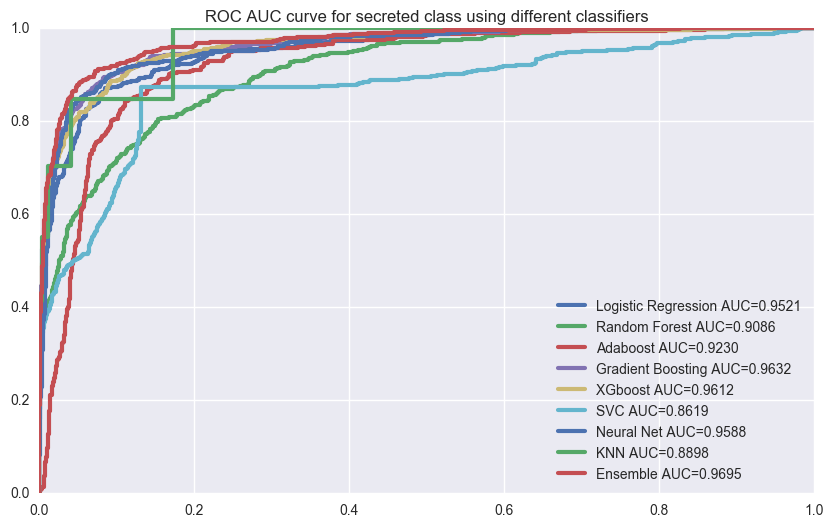

In [32]:
f, axes = plt.subplots(1, figsize=(10, 6))
for [fpr, tpr, roc_auc],label in zip(rocaucs_list,['Logistic Regression', 'Random Forest', 'Adaboost','Gradient Boosting', 
                       'XGboost', 'SVC', 'Neural Net','KNN', 'Ensemble']):
    lab = '%s AUC=%.4f' % (label,roc_auc)
    axes.step(fpr, tpr, lw=3,label=lab)
axes.legend(loc='lower right', fontsize='small')
plt.title('ROC AUC curve for secreted class using different classifiers')
plt.show()

In [ ]:
# Ensemble hyperparameter tuning
# Boolean switch to tune

if False:
    optimization_df = pd.DataFrame(columns=['rank','accuracy','lr__C', 'rf__n_estimators', 'rf__max_depth', 
                                            'rf__min_samples_split', 'rf__min_samples_leaf', 
                                            'rf__max_features','ada__n_estimators','ada__learning_rate',
                                           'gb__n_estimators','gb__max_depth','gb__min_samples_split',
                                           'gb__min_samples_leaf','gb__max_feature','xg__gamma',
                                           'xg__learning_rate','xg__reg_lambda','xg__reg_alpha',
                                           'xg__max_depth','xg__min_child_weight','SVC__C','SVC__gamma',
                                           'NN__hidden_layer_sizes','NN__activation','NN__solver',
                                           'NN__learning_rate','NN__alpha','KNN__n_neighbors','KNN__p'])
    optimized_list = []
    optimized_dict = {}

    # Utility function to report best scores
    def report(results, n_top=1):
        for i in range(1, n_top + 1):
            candidates = np.flatnonzero(results['rank_test_score'] == i)
            for candidate in candidates:
                optimized_dict = {'lr__C': results['param_lr__C'].data[candidate], 
                                  'rf__n_estimators': results['param_rf__n_estimators'][candidate],
                                  'rf__max_depth': results['param_rf__max_depth'][candidate],
                                  'rf__min_samples_split': results['param_rf__min_samples_split'][candidate],
                                  'rf__min_samples_leaf': results['param_rf__min_samples_leaf'][candidate],
                                  'rf__max_feature': results['param_rf__max_feature'][candidate],
                                  'ada__n_estimators': results['param_ada__n_estimators'][candidate],
                                  'ada__learning_rate': results['param_ada__learning_rate'][candidate],
                                  'gb__n_estimators': results['param_gb__n_estimators'][candidate],
                                  'gb__max_depth': results['param_rf__max_depth'][candidate],
                                  'gb__min_samples_split': results['param_gb__min_samples_split'][candidate],
                                  'gb__min_samples_leaf': results['param_gb__min_samples_leaf'][candidate],
                                  'gb__max_feature': results['param_gb__max_feature'][candidate],
                                  'xg__gamma': results['param_xg__gamma'].data[candidate],
                                  'xg__learning_rate': results['param_xg__learning_rate'].data[candidate],
                                  'xg__reg_lambda': results['param_xg__reg_lambda'].data[candidate],
                                  'xg__reg_alpha': results['param_xg__reg_alpha'].data[candidate],
                                  'xg__max_depth': results['param_xg__max_depth'].data[candidate],
                                  'xg__min_child_weight': results['param_xg__min_child_weight'].data[candidate],
                                  'SVC__C': results['param_SVC__C'].data[candidate],
                                  'SVC__gamma': results['param_SVC__gamma'].data[candidate],
                                  'NN__hidden_layer_sizes': results['param_NN__hidden_layer_sizes'].data[candidate],
                                  'NN__activation': results['param_NN__activation'].data[candidate],
                                  'NN__solver': results['param_NN__solver'].data[candidate],
                                  'NN__learning_rate': results['param_NN__learning_rate'].data[candidate],
                                  'NN__alpha': results['param_NN__alpha'].data[candidate],
                                  'KNN__n_neighbors': results['param_KNN__n_neighbors'].data[candidate],
                                  'KNN__p': results['param_KNN__p'].data[candidate],
                                  'accuracy': results['mean_test_score'][candidate]
                                 }
                optimized_list.append(optimized_dict)
                print("Model with rank: {0}".format(i))
                print("Mean accuracy score: {0:.3f})".format(
                      results['mean_test_score'][candidate]))
                print("Parameters: {0}".format(results['params'][candidate]))            

    from time import time
    # specify parameters and distributions to sample from
    params = {
                'lr__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                'rf__n_estimators': [120,300,500,800,1200],
                'rf__max_depth':[5,8,15,25,30,None],
                'rf__min_samples_split': [1,2,5,10,15,100],
                'rf__min_samples_leaf': [1,2,5,10],
                'rf__max_features': ['log2','sqrt',None],
                'ada__n_estimators': [50,120,300,500,800],
                'ada__learning_rate': [0.01,0.015,0.025,0.05,0.1],
                'gbr__learning_rate': [0.01,0.015,0.025,0.05,0.1],
                'gbr__n_estimators': [50,120,300,500,800],
                'xg__learning_rate': [0.01,0.015,0.025,0.05,0.1],
                'xg__gamma': [0.05,0.1,0.3,0.5,0.7,0.9,1.0],
                'xg__max_depth': [3,5,7,9,12,15,17,25],
                'xg__min_child_weight':[1,3,5,7],
                'xg__reg_lambda': [0.001,0.01,0.1,1.0],
                'xg__reg_alpha': [0,0.1,0.5,1.0],
                'SVC__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                'SVC__gamma': ['auto', 0.01, 0.1, 0.5, 1.0],
                'NN__hidden_layer_sizes':[(50,),(100,),(200,),(300,)],
                'NN__activation':['identity', 'logistic', 'tanh', 'relu'],
                'NN__solver':['lbfgs', 'sgd', 'adam'],
                'NN__learning_rate':['constant', 'invscaling', 'adaptive'],
                'NN__alpha': [0.001,0.01,0.1,1.0],
                'KNN__n_neighbors':[2,4,8,16],
                'KNN__p':[2,3]
              }

    eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('ada', clf3), ('gbr', clf4), ('xg', clf5),
                                       ('SVC', clf6), ('NN', clf7), ('KNN', clf8)], voting='soft', 
                            weights=weights_list.tolist())

    # run randomized search
    n_iter_search = 2
    random_search = RandomizedSearchCV(eclf, param_distributions=params,n_iter=n_iter_search)
    start = time()
    random_search.fit(X, y)
    print("Randomized Search CV took %.2f seconds for %d candidates"
          " parameter settings." % ((time() - start), n_iter_search))
    record(random_search.cv_results_)

    # Save params
    optimization_df = optimization_df.append(optimized_list)
    optimization_df.to_csv('OptizedEnsembleParams.csv')

In [45]:
# Feature importance using forest
X = features_df_scaled
y = labels_enc

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

rf = RandomForestClassifier()
importances = rf.fit(X_train, y_train).feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print("important Features:")
important = list()
for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
        important.append([indices[f],importances[indices[f]]])
# Print the the useless features
print("Less important Features:")
useless = list()
for f in range(X.shape[1]):
    if importances[indices[f]] == 0.0:
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
        useless.append([indices[f],importances[indices[f]]])

important Features:
1. feature 65 (0.026997)
2. feature 5 (0.024891)
3. feature 10 (0.023746)
4. feature 1 (0.023070)
5. feature 37 (0.022559)
6. feature 79 (0.022022)
7. feature 70 (0.022004)
8. feature 31 (0.020781)
9. feature 7 (0.019287)
10. feature 0 (0.018301)
11. feature 42 (0.016985)
12. feature 30 (0.016141)
13. feature 2 (0.016079)
14. feature 43 (0.016042)
15. feature 18 (0.015838)
16. feature 4 (0.015833)
17. feature 78 (0.015553)
18. feature 8 (0.015140)
19. feature 3 (0.015113)
20. feature 12 (0.014614)
21. feature 29 (0.014226)
22. feature 17 (0.014075)
23. feature 19 (0.013723)
24. feature 25 (0.013579)
25. feature 11 (0.013554)
26. feature 47 (0.013278)
27. feature 6 (0.013257)
28. feature 14 (0.012991)
29. feature 85 (0.012825)
30. feature 90 (0.012034)
31. feature 28 (0.011881)
32. feature 23 (0.011442)
33. feature 24 (0.011272)
34. feature 49 (0.011094)
35. feature 71 (0.011058)
36. feature 20 (0.010911)
37. feature 35 (0.010755)
38. feature 16 (0.010734)
39. featur

In [47]:
important_df = pd.DataFrame(important)
important_df.columns = ['Feature no','Importance']
important_df[:10]

,Feature no,Importance
0,65,0.026997
1,5,0.024891
2,10,0.023746
3,1,0.023070
4,37,0.022559
5,79,0.022022
6,70,0.022004
7,31,0.020781
8,7,0.019287
9,0,0.018301


In [49]:
useless_df = pd.DataFrame(useless)
useless_df.columns = ['Feature no','Importance']
useless_df

,Feature no,Importance
0,51,0.0
1,34,0.0


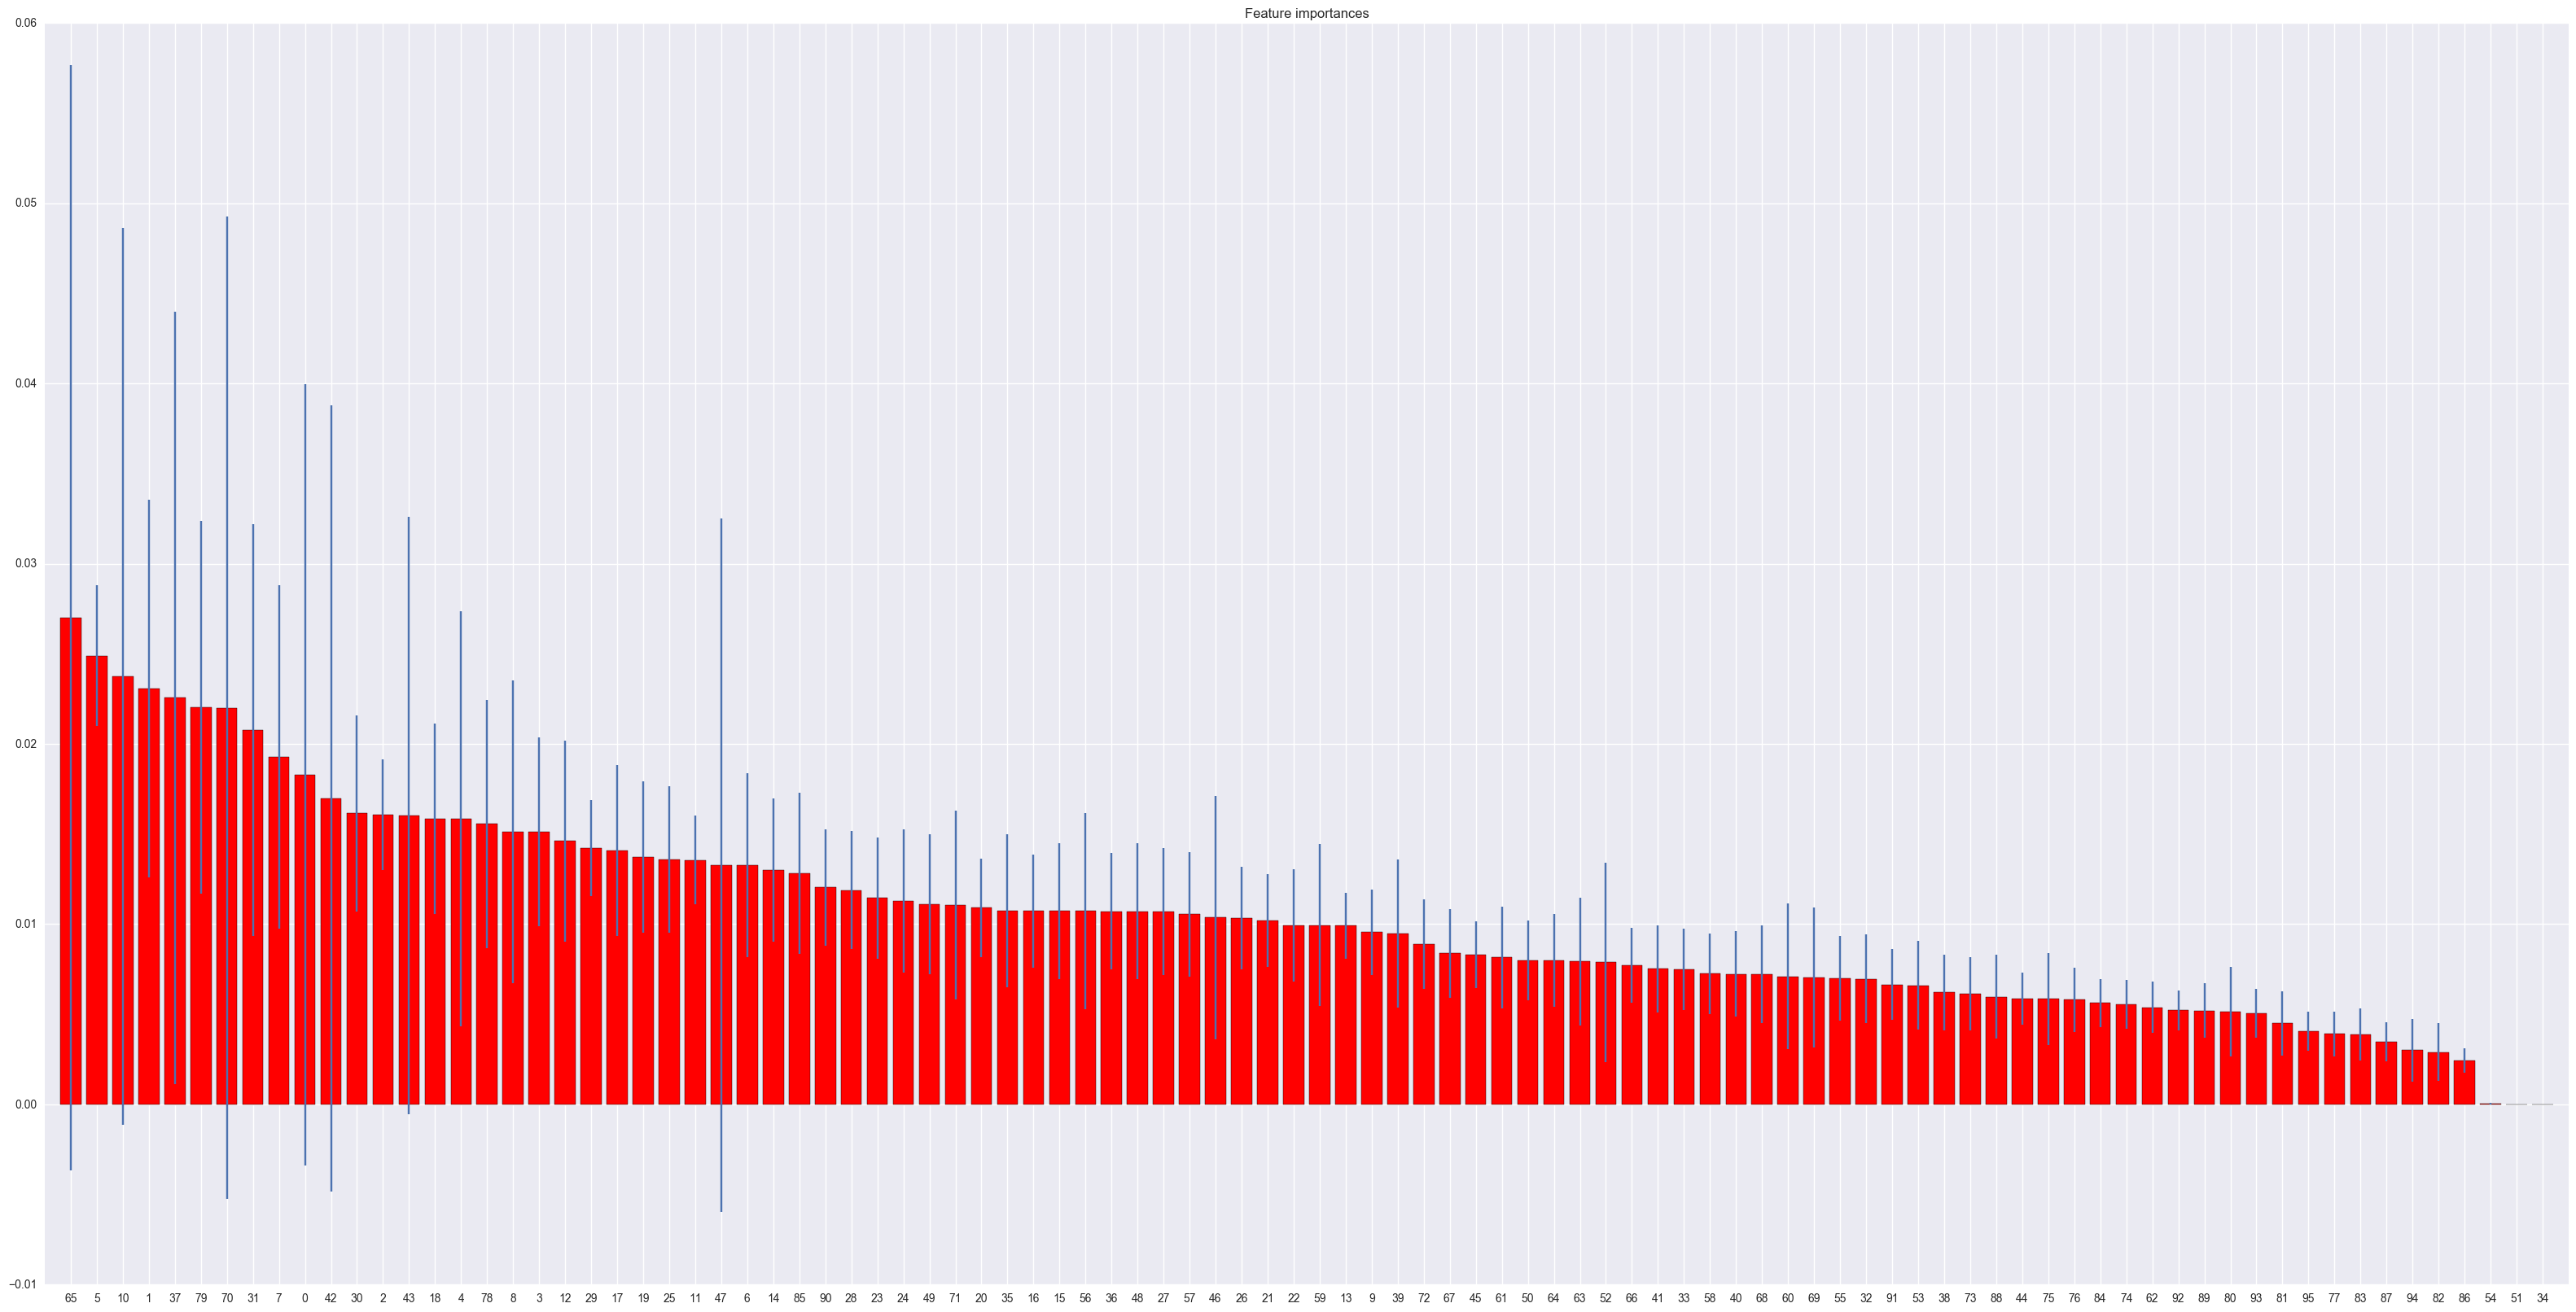

In [83]:
# Plot the feature importances of the forest
plt.figure(figsize=(40,20))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
# Feature importance to label prediction
from treeinterpreter import treeinterpreter as ti
feat_importance=[]
feat_name=[]
prediction, bias, contributions = ti.predict(rf, X_test)

In [ ]:
for c, feature in zip(contributions[0], 
                             features_df.columns.tolist()):
    feat_name.append(feature)
    feat_importance.append(c)

In [ ]:
feat_imp_df = pd.DataFrame()
feat_imp_df['feature'] = feat_name
feat_imp_df = pd.concat([feat_imp_df,pd.DataFrame(feat_importance, columns=['cyto','mito','nucleus','secreted'])], axis=1)

first_feats = feat_imp_df[:9]
amino_pct_feats = feat_imp_df[9:29]
first_feats = first_feats.append(feat_imp_df[29:33])

In [ ]:
sns.set()
sns.heatmap(first_feats, annot=True)
plt.title('Protein Analysis Features Importance')
plt.show()

In [ ]:
sns.heatmap(amino_pct_feats, annot=True)
plt.title('Amino Acid% Features Importance')
plt.show()

In [ ]:
# Feature selection
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
k_no = np.arange(5,X.shape[1], 20)
acc=[]
score_stds=[]

for ks in k_no:
    fs = Pipeline([
      ('feature_selection', SelectKBest(k = ks)),
      ('classification', clf1)
    ])
    
    this_scores = cross_val_score(fs, X, y, scoring='accuracy')
    acc.append(this_scores.mean()*100)
    score_stds.append(this_scores.std())

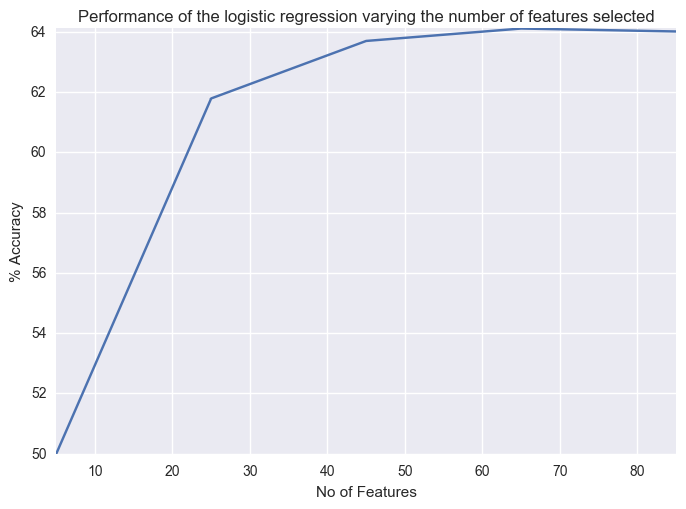

In [36]:
plt.errorbar(k_no, acc, np.array(score_stds))

plt.title(
    'Performance of the logistic regression varying the number of features selected')
plt.xlabel('No of Features')
plt.ylabel('% Accuracy')

plt.axis('tight')
plt.show()

In [69]:
# Drop useless features before running the ensemble
# for i,j in useless:
#     X_train = X_train.drop(X_train.columns[i], 1)

# Fit ensemble and predict 
y_pred_eclf = eclf.fit(X_train, y_train).predict(X_test)
print('Ensemble Accuracy =', metrics.accuracy_score(y_test, y_pred_eclf))

C:\Users\SAID_ABDULLAHI\Anaconda2\envs\python35\lib\site-packages\sklearn\linear_model\base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


Ensemble Accuracy = 0.701481749187


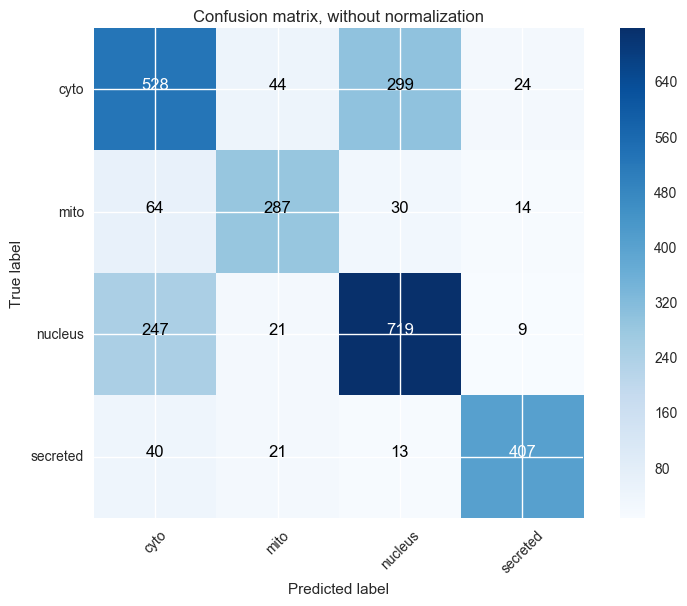

In [90]:
# Confusion matrix
cnf = metrics.confusion_matrix(y_test, y_pred_eclf)

# Plot confusion matrix courtesy of sklearn docs
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf, classes=labels.unique().tolist(),
                      title='Confusion matrix, without normalization')
plt.show()

In [79]:
# Evaluation Metrics
print(metrics.classification_report(y_test, y_pred_eclf))

             precision    recall  f1-score   support

          0       0.60      0.59      0.60       895
          1       0.77      0.73      0.75       395
          2       0.68      0.72      0.70       996
          3       0.90      0.85      0.87       481

avg / total       0.70      0.70      0.70      2767



In [80]:
# Predict test labels
test_labels = eclf.fit(X_train,y_train).predict(test_df)
test_labels = le.inverse_transform(test_labels)

In [84]:
# Find the confidence scores for predictions
predprobs = eclf.predict_proba(test_df)
confidence_df = pd.DataFrame(predprobs)
confidence = confidence_df.max(axis=1)

In [87]:
# Output
final_output = pd.DataFrame()
final_output['Seq'] = blindidentifiers
final_output['prediction'] = test_labels
final_output['measure'] = 'Confidence'
final_output['confidence'] = (confidence*100).round(1).astype(str) + '%'
final_output

,Seq,prediction,measure,confidence
0,SEQ677,cyto,Confidence,38.2%
1,SEQ231,secreted,Confidence,48.2%
2,SEQ871,secreted,Confidence,46.8%
3,SEQ388,nucleus,Confidence,54.8%
4,SEQ122,nucleus,Confidence,57.5%
5,SEQ758,cyto,Confidence,48.3%
6,SEQ333,cyto,Confidence,61.0%
7,SEQ937,cyto,Confidence,69.1%
8,SEQ351,cyto,Confidence,55.4%
9,SEQ202,mito,Confidence,51.7%
